In [1]:
import matplotlib
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm
import pandas as pd
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from adjustText import adjust_text
from scipy.stats import pearsonr, spearmanr
matplotlib.rc('font', family='Arial') 


import matplotlib as mpl


mpl.rcParams.update({
    'font.family':          'sans-serif',
    'font.sans-serif':      ['Arial'],
    'mathtext.fontset':     'custom',
    'mathtext.rm':          'Arial',
    'mathtext.it':          'Arial:italic',
    'mathtext.bf':          'Arial:bold',
    'mathtext.cal':         'Arial',        # for calligraphic if you like
})


In [2]:
pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df=pop_df[['Country Code','2019']].dropna()
pop_df['2019']=pop_df['2019'].astype(int)
possible_countries=pop_df.query(" `2019` >=1000000")['Country Code'].values
possible_countries=[x.lower() for x in possible_countries]


excluded_iso3_codes = [
    "IRL",  # Ireland
    "SSD",  # South Sudan
    "SDN",  # Sudan
    "COG",  # Republic of the Congo
    "COD",  # Democratic Republic of the Congo
    "GIN",  # Guinea
    "GNB",  # Guinea-Bissau
    "GNQ",  # Equatorial Guinea
    "PNG",  # Papua New Guinea
    "XKX",  # Kosovo (unofficial)
    "MNE",  # Montenegro
    "SRB",  # Serbia
    "TLS",   # Timor-Leste
    'GEO'

]
excluded_iso3_codes=[c.lower() for c in excluded_iso3_codes]
possible_countries=list(set(possible_countries)-set(excluded_iso3_codes))


In [3]:

def plotA(ax, column, label):
    df = pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched_new.csv").dropna(subset=['countrycode'])
    years=np.arange(2002, 2020, 1)
    
    df=df[df['year'].isin(years)].reset_index(drop=True)
    Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
    rev_Country_list={Country_list[key]: key for key in Country_list}
    df['countrycode']=df['countrycode'].apply(lambda x: x.lower())
    df=df[df['countrycode'].isin(possible_countries)]
    def plot_time(df, column, column_name,ax, log=True, show_mean=True, y_to_show=None):
      List=[['egy','tun'], ['lby', 'syr', 'yem'],  [ 'bhr', 'jor', 'kwt', 'mar', 'omn']]
      mean_df=df.groupby('year')[column].mean().reset_index()
      median_df=df.groupby('year')[column].median().reset_index()
      Q25_df=df.groupby('year')[column].quantile(.25).reset_index()
      Q75_df=df.groupby('year')[column].quantile(.75).reset_index()
      Unrest_times= {
        'Egypt': [(2011, 2014)], 'Tunisia': [(2010.5, 2012)], 'Yemen': [(2011, 2019)], 'Syria': [(2011, 2019)],
        'Libya': [(2011, 2019)], 'Bahrain': [(2011, 2011)], 'Kuwait': [(2011, 2011)], 'Morocco': [(2011, 2011)],
        'Oman': [(2011, 2011)], 'Jordan': [(2011, 2011)]
      }      
      markers=['o', 'v', '^', 'x', 's', 'd', '>', '<', 'p', '+']
      NC=0
      legend_to_show=True
      for k, country_list in enumerate(List):
        
        NB=0
        if  k==0:
            ax[k].plot(mean_df['year'].round(),mean_df[column],linestyle=':', color='k',linewidth=0.6)
            ax[k].plot(median_df['year'].round(),median_df[column],linestyle='--', color='k',linewidth=0.6)
            ax[k].fill_between(median_df['year'].round(),Q25_df[column],Q75_df[column], color='gray', alpha=0.2)

            #ax[-1].fill_between(median_df['year'].round(),Q25_df[column],Q75_df[column], color='gray', alpha=0.2)
            

        else:
            ax[k].plot(mean_df['year'].round(),mean_df[column],linestyle=':', color='k',linewidth=0.6)
            ax[k].plot(median_df['year'].round(),median_df[column],linestyle='--', color='k',linewidth=0.6)
            ax[k].fill_between(median_df['year'].round(),Q25_df[column],Q75_df[column], color='gray', alpha=0.2)
            
        for country in country_list:
          filt_df=df[df['countrycode']==country]
          #print(filt_df)
          if k==0:
            ax[-1].plot(filt_df['year'].round(),filt_df[column], marker=markers[NC], markersize=4, color=colors[NC],linewidth=0.6)

          ax[k].plot(filt_df['year'].round(),filt_df[column], marker=markers[NC], markersize=4, color=colors[NC],linewidth=0.6, label=rev_Country_list[country.upper()])
          if country=='egy':
                color=colors[0]
          elif country =='tun':
            color=colors[1]
          else:
            color='yellow'
          if NC<=2 and color!='yellow':
              for spans in Unrest_times[rev_Country_list[country.upper()]]:
                    start, end=spans
                    if  legend_to_show:
                        ax[k].axvspan(start, end, alpha=0.2, color=color, label=f'Unrest {rev_Country_list[country.upper()]}')
                        
                    else:
                        ax[k].axvspan(start, end, alpha=0.2, color=color)

          elif NC==len(country_list) and color=='yellow':
             for spans in Unrest_times[rev_Country_list[country.upper()]]:
                    start, end=spans
                    print(k)
                    if legend_to_show and k==len(country_list)-1:
                        ax[k].axvspan(start-0.5, end+0.5, alpha=0.2, color=color)
                    else:
                        ax[k].axvspan(start-0.5, end+0.5, alpha=0.2, color=color)
                        

          NC+=1
          
      Locs=['lower left', 'upper left', 'upper left']
      ncols=[2, 1, 1]
      for axes, loc, ncol in zip(ax[:3], Locs,ncols ):
        axes.legend(frameon=False, ncol=ncol, loc=loc)
        if y_to_show:
          axes.axhline(y_to_show,linestyle='-', color='cyan' )
        #axes.axvline(2011,linestyle='-', color='m' )
        axes.set_xticks(np.arange(2002, 2020 ),[str(tick) if i % 4 == 0 else '' for i, tick in enumerate(np.arange(2002, 2020 ))])


        axes.set_xlim(2001.5, 2019.5)
        axes.set_xlabel('Year', fontsize=15)

       
        if log:
          axes.set_yscale('log')

      ax[0].set_ylabel(column_name, fontsize=15)
    
    plot_time(df,column, label,ax, log=False, show_mean=True)
    
    

In [4]:
colors=[
    "#E69F00",  # Orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Bluish Green
    "#6929C4",  # Purple 70
    "#CC79A7",  # Reddish Purple

    "#0072B2",  # Blue
    "#D55E00",  # Vermillion
    # Three additional color‑blind‑friendly hues from Paul Tol’s “Muted” scheme:
    "#999933",  # Teal
    "#8A3800",  # Magenta 50
    "#882255",  # Wine (added)
]


In [5]:
def plotC(ax):
    Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
    rev_Country_list={Country_list[key]: key for key in Country_list}
    abbr=[country.lower() for country in Country_list.values()]
    c_list=list(Country_list.values())
    df=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_countryflows_enriched_new.csv")
    years=np.arange(2002, 2020, 1)
    df=df[df['year'].isin(years)].reset_index(drop=True)
    filt_df=df[df['iso3codefrom'].isin(c_list)].reset_index(drop=True)
    before_df=filt_df[filt_df['year'].isin(np.arange(2002, 2011, 1))].groupby(by=['countrynamefrom','countrynameto']).sum().reset_index()[['n_migrations','countrynamefrom','countrynameto']].rename(columns={'n_migrations':'n_migrations_before'})
    after_df=filt_df[filt_df['year'].isin(np.arange(2011, 2020, 1))].groupby(by=['countrynamefrom','countrynameto']).sum().reset_index()[['n_migrations','countrynamefrom','countrynameto']].rename(columns={'n_migrations':'n_migrations_after'})

    compare_df=before_df.merge(after_df, how='outer', on=['countrynamefrom','countrynameto']).fillna(0)
    
    compare_df['difference']=compare_df['n_migrations_after']-compare_df['n_migrations_before']
    compare_df ['difference']/=9
    heatmap_data = compare_df.pivot(index='countrynameto', columns='countrynamefrom', values='difference')
    
    for col in heatmap_data.columns:
            if col in heatmap_data.index:
              heatmap_data.loc[col][col]=np.nan
        
    Results=[]
    row_sums = heatmap_data.sum(axis=1)
    heatmap_data['sum']=row_sums
    df_sorted = heatmap_data.loc[row_sums.sort_values(ascending=False).index][:10 :]
    Results.append(df_sorted['sum'])
    df_sorted.rename(index={'United States':'USA','United States of America':'USA', 'United Kingdom':'UK', 'United Arab Emirates':'UAE','Egypt, Arab Rep.':'Egypt'}, columns={'Syrian Arab Republic':'Syria','Egypt, Arab Rep.':'Egypt','Yemen, Rep.':'Yemen'}, inplace=True)
    custom_order=list(Country_list.keys())+['sum']
    df_sorted = df_sorted[custom_order]
    
    sns.heatmap(df_sorted.iloc[:, : -1].fillna(0).astype(int), ax=ax, annot=True, cbar=False,center=0, cmap='BrBG',fmt='.0f',annot_kws={"fontsize":10})

    ax.set_ylabel('Scholarly migration destination', fontsize=15)
    ax.set_xlabel('Target country', fontsize=15)
    return Results

In [6]:
def plot_subsub(axis, Results):
    
    for ax, res in zip(axis, Results):
        # Create DataFrame
        df = res.reset_index()

        # Set index to country names for better plotting
        df.set_index('countrynameto', inplace=True)
        norm = matplotlib.colors.LogNorm()  # Normalization for the colormap
        sns.heatmap(df[['sum']], annot=True, fmt=".0f", cmap='viridis', cbar=False, norm=norm, ax=ax)
        
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_xlabel('')
        ax.set_ylabel('')

1
2


C:\Users\Yasaman\AppData\Local\Temp\ipykernel_40052\1135620010.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  heatmap_data.loc[col][col]=np.nan
The PostScript backend does not support transparency; partially transparent artists will be

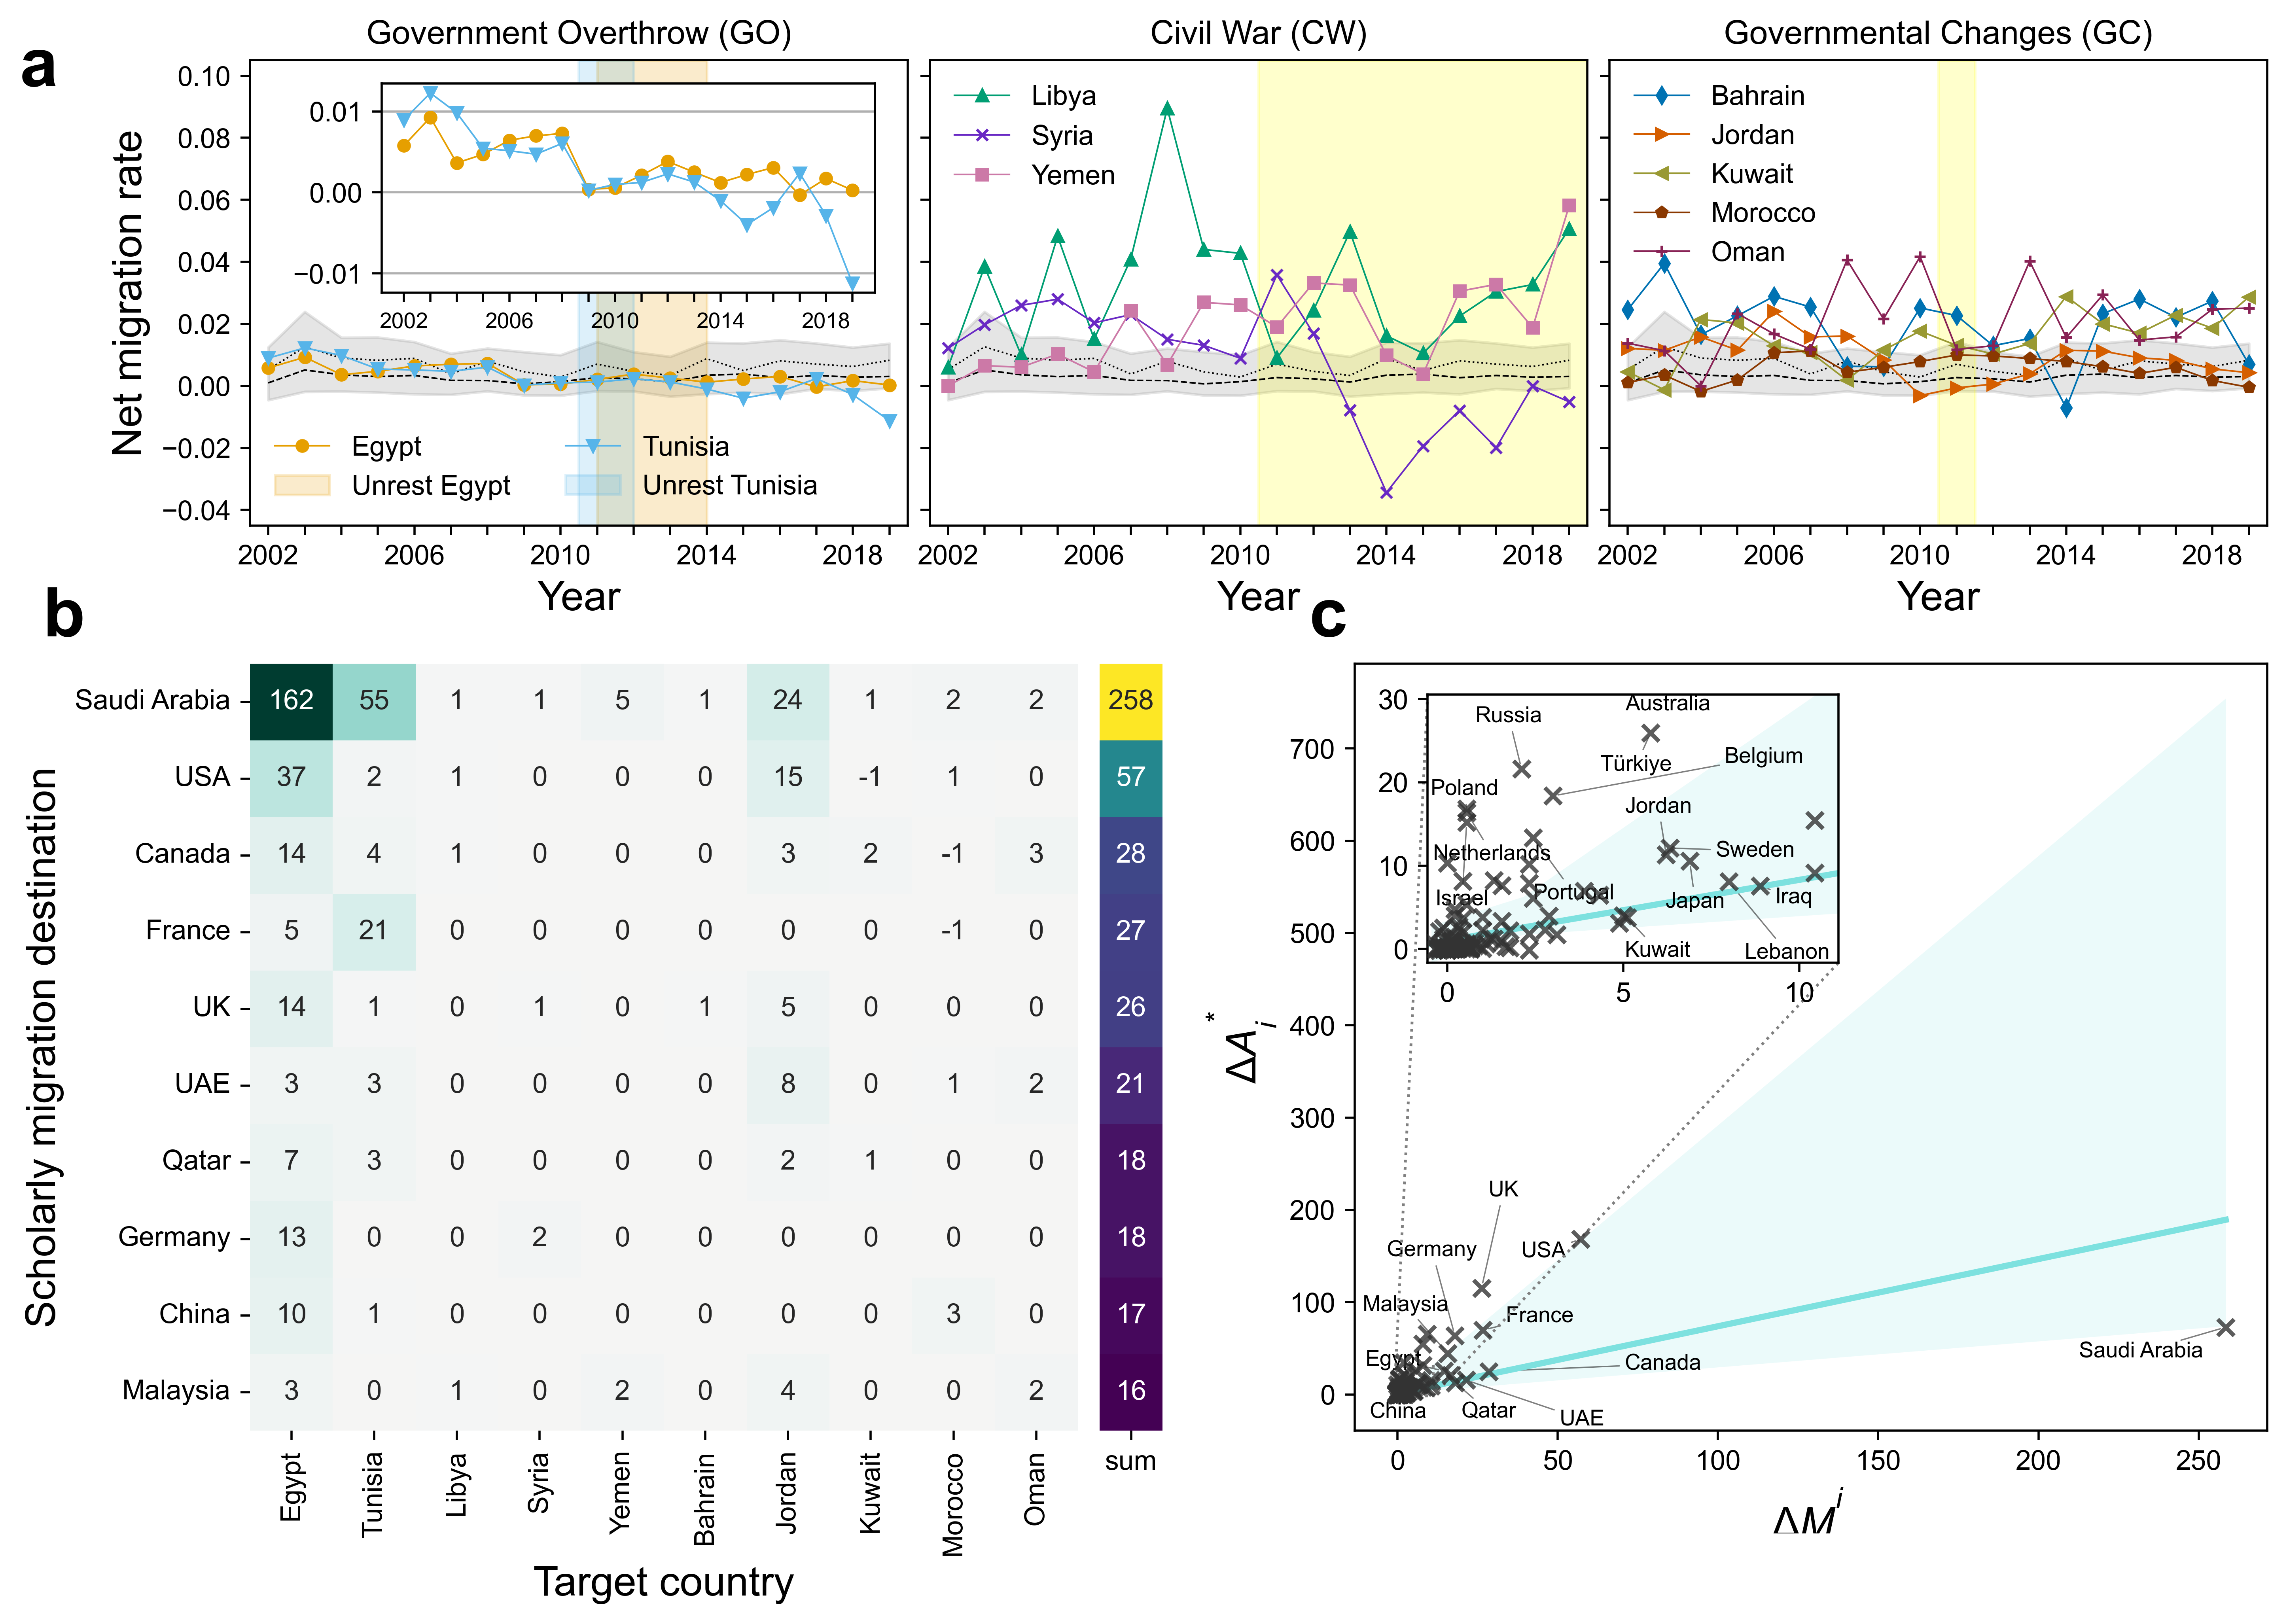

In [15]:
# Create a new figure with custom subplot layout
fig = plt.figure(figsize=(12, 9), dpi=500)
# Create grid specification for subplots
gs = fig.add_gridspec(14, 24)

# Define the subplots based on the grid specification
# Four plots on the top row

ax1 = fig.add_subplot(gs[:5, :8])
ax1.text(-0.35, 1.05, 'a', transform=ax1.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')

ax2 = fig.add_subplot(gs[:5, 8:16])

ax3 = fig.add_subplot(gs[:5, 16:24])

ins = ax1.inset_axes([0.2,0.5,0.75,0.45])


plotA([ax1,ax2, ax3, ins], 'netmigrationrate', 'Net migration rate')
ax1.set_ylim(-0.045, 0.105)
ax2.set_ylim(-0.045, 0.105)
ax3.set_ylim(-0.045, 0.105)

ax2.set_yticklabels([])
ax3.set_yticklabels([])
ins.set_xticks(np.arange(2002, 2020 ),[str(tick) if i % 4 == 0 else '' for i, tick in enumerate(np.arange(2002, 2020 ))], fontsize=8)
ins.grid(axis='y')



ax4 = fig.add_subplot(gs[6:, 0:10])
ax4.text(-0.25, 1.1, 'b', transform=ax4.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')
res=plotC(ax4)

ax9 = fig.add_subplot(gs[6:, 10])
plot_subsub([ax9], res)


ax10 = fig.add_subplot(gs[6:, 13:])
ax10.text(-0.05, 1.1, 'c', transform=ax10.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')

ins = ax10.inset_axes([0.08,0.61,0.45,0.35])

country_codes=pd.read_csv(r"C:\Users\Yasaman\Downloads\iso3.csv")
country_codes['iso3']=[c.lower() for c in country_codes['iso3']]
map={country_codes.iloc[c]['iso3']: country_codes.iloc[c]['name'] for c in range(len(country_codes))}
map['irn']='Iran'
map['usa']='USA'
map['gbr']='UK'
map['rus']='Russia'
map['syr']='Syria'
map['are']='UAE'
res_df=res_df.sort_values(by=['dif_migration'], ascending=False).reset_index(drop=True)

sns.regplot(res_df, x='dif_migration', y='dif_attention' ,marker="x", color=".2", line_kws=dict(color="#7DE1DF"),ax=ax10,  scatter_kws={"zorder":10}, robust=True)
ax10.set_ylabel(r'$\Delta A_i^*$', fontsize=15)
ax10.set_xlabel(r'$\Delta M^i_*$', fontsize=15)
res_df2=res_df.query('dif_migration <=10')
sns.regplot(res_df, x='dif_migration', y='dif_attention' ,marker="x", color=".2", line_kws=dict(color="#7DE1DF"),ax=ins,  scatter_kws={"zorder":10}, robust=True)
ins.set_ylabel(r'', fontsize=10)
ins.set_xlabel(r'', fontsize=10)
ins.set_xlim(-5/9, 100/9)
ins.set_ylim(-15/9, 275/9)

####
points=[]
# Annotate each point
for line in range(sum((res_df['dif_migration']>=100/8))):

    x = res_df.dif_migration[line]
    y = res_df.dif_attention[line]
    label =map[res_df.country[line]]
    points+=[ax10.text(x, y, label,
                    fontsize=8, ha='center', va='center')]

adjust_text(points, arrowprops=dict(arrowstyle="-", color='k', lw=0.5, alpha=.5), expand=(1.5, 2.5))        


###

points2=[]
# Annotate each point
for line in res_df2[((res_df2['dif_attention']>120/9)&(res_df2['dif_attention']<260/9))|((res_df2['dif_migration']>40/8)&(res_df2['dif_attention']<275/8))].index:

    x = res_df2.dif_migration[line]
    y = res_df2.dif_attention[line]
    label =map[res_df2.country[line]]
    points2+=[ins.text(x, y, label,
                    fontsize=8, ha='center', va='center')]

adjust_text(points2, arrowprops=dict(arrowstyle="-", color='k', lw=0.5, alpha=.5), expand=(1.5, 2), ax=ins)        


#ax1.indicate_inset_zoom(ins, edgecolor="black")

mark_inset(ax10, ins, loc1=2, loc2=4, fc="none", ec="0.5", linestyle=':')

ax1.set_title('Government Overthrow (GO)')
ax2.set_title('Civil War (CW)')
ax3.set_title('Governmental Changes (GC)')

fig.subplots_adjust(left=0.125 ,right=0.975, top=0.97, bottom=0.2, hspace=.6, wspace=0.35)
#fig.tight_layout()
fig.savefig('Figure8.pdf')
fig.savefig('Figure8.tiff')
fig.savefig('Figure8.eps')

In [9]:
def find_df_attention(df, start_year, middle_year1, middle_year2, end_year):
    Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
    rev_Country_list={Country_list[key]: key for key in Country_list}
    abbr=[country.lower() for country in Country_list.values()]
    df=df.rename(columns={'year':'Year', 'aggregated_value':'count', 'country':'Mention_country'})
    before_df=df[(df['Year'].isin(np.arange(start_year, middle_year1, 1)))&(df['Mention_country'].isin(abbr))&(df['Mention_country']!=df['affiliation_country'])].groupby(by=['affiliation_country'])['count'].sum(numeric_only=True).reset_index().rename(columns={'count':'target_count_before'})

    after_df=df[(df['Year'].isin(np.arange(middle_year2, end_year, 1)))&(df['Mention_country'].isin(abbr))&(df['Mention_country']!=df['affiliation_country'])].groupby(by=['affiliation_country'])['count'].sum(numeric_only=True).reset_index().rename(columns={'count':'target_count_after'})

    new_df=before_df.merge(after_df, on=['affiliation_country'], how='outer').fillna(0)
    return new_df.rename(columns={'affiliation_country':'country'})

physical_sciences=[ 'MATH', 'ENGI', 'PHYS', 'COMP','MULT']
df_attention=pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df_attention=df_attention[~(df_attention['subjarea'].isin(physical_sciences))]
df_attention=df_attention.groupby(['year', 'affiliation_country','country']).sum(numeric_only=True).reset_index()
res_attention=find_df_attention(df_attention, 2002, 2011, 2011, 2020)
res_attention['dif']=res_attention['target_count_after']-res_attention['target_count_before']

df_migration=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_countryflows_enriched_new.csv")
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]
before_years=np.arange(2002, 2011, 1)
after_years=np.arange(2011, 2020, 1)
before_df_migration=df_migration.query(
    "iso3codefrom.str.lower() in @abbr and iso3codefrom != iso3codeto and year in @before_years"
).groupby(['iso3codeto'])['n_migrations'].sum().reset_index().rename(columns={'n_migrations':'Target_migration_before'})


after_df_migration=df_migration.query(
    "iso3codefrom.str.lower() in @abbr and iso3codefrom != iso3codeto and year in @after_years"
).groupby(['iso3codeto'])['n_migrations'].sum().reset_index().rename(columns={'n_migrations':'Target_migration_after'})



res_migration=before_df_migration.merge(after_df_migration, how='outer').fillna(0)
res_migration['dif']=res_migration['Target_migration_after']-res_migration['Target_migration_before']
res_migration['iso3codeto']=res_migration['iso3codeto'].apply(lambda x: x.lower())
res_migration=res_migration.rename(columns={'iso3codeto':'country'})

res_df=res_attention.merge(res_migration, how='outer', on=['country'], suffixes=['_attention', '_migration']).fillna(0)
res_df=res_df[['country', 'dif_attention', 'dif_migration']]
res_df=res_df[res_df['country'].isin(possible_countries)]
res_df['dif_attention']/=9
res_df['dif_migration']/=9


In [10]:
correlation_coefficient, p_value = pearsonr(res_df['dif_migration'], res_df['dif_attention'])
print("Pearson Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

correlation_coefficient, p_value = spearmanr(res_df['dif_migration'], res_df['dif_attention'])
print("Spearman Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)



Pearson Correlation Coefficient: 0.5041877562261686
P-value: 1.1748055995591404e-10
Spearman Correlation Coefficient: 0.7415929419954825
P-value: 2.154042495875456e-26
